#Xenon-135 precursor chain Numerical Solver with Fission-Gas Stripping

This numerical solver code is used to simulate the Xenon-Iodine system of equations that
dominates the fission product neutron poison concentration in the fuel of an operating nuclear reactor.

This is an object oriented program, allowing each method under class-Nuclide to operate on each nuclide in the decay chain (namely $^{135}Xe$ and $^{135}I$). The methods in this class represent each term of the system of DiffEQs. The timestep method calls each previous method to calculate the change in concentration based off of each term (generation or consumption), then applies arithmetic to calculate the total time-rate-of-change ($\frac{dNi}{dt}$)

###Clear variables from workspace

In [501]:
%reset -f

###Importing the necessary packages

numpy for arrays

matplotlib.pyplot for plotting

tqdm for progress bars (the time loops in this code take dozens of seconds and progress bars made with tqdm are much more visually appealing than manual print statements etc.)

In [502]:

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
from copy import copy

##Set Up the framework for the simulation

###Define a global class that defines the constants needed to describe the core as well as gives the ability (through class methods) to modify conditions, e.g. simulate a scram or power transient

In [503]:
class Core: #Defining constants and allowing parameter changing (e.g. scram or power transient)
    #Constants
    #tau = 130 #sec // flow period of molten salt
    sigma_F = 1e-24*180 #cm-2 
    gamma = {'I':0.0639,'Xe':0.00237} #dictionaries are used to assign constants to instances of class Nuclide
    lamda = {'I':2.87e-5, 'Xe':2.09e-5} #sec^-1
    sigma = {'I':0,   'Xe':1e-24*4.3e5} #cm^2 
    H = {'I':None,'Xe':1e-4} #c_g/c_l

    #FUEL... 18mol% HALEU-UF4 in FLiNaK @ 19.75% enrichment
    mole = 0.18
    enrichment = 0.1975 
    Avo = 6.0221408e23
    mass_den = 3.60510 #g/cm3 @915K
    MW = 35.555
    N = Avo*mass_den/MW #atoms/cm3
    basis = 5*mole+2*(1-mole)
    molefrac235 = mole/basis*enrichment
    print(f'{molefrac235} molefrac U235')
    Sigma_F = sigma_F*N*molefrac235 #cm-1
    print(f'Sigma_F^f{Sigma_F} cm-1')
    #Parameters (initial)
    flux = 1e14 #n/cm2/s 
    FissionRate = Sigma_F*flux #cm-3.s
    print(f'Fission Rate: {FissionRate} cm-3.s')
    PowerDensity = FissionRate*200 #MeV/cm3.s
    Volume = 4.29116E5 #cm3
    Power = PowerDensity*Volume*1.6022e-13 #W
    print(f'{np.sum(Power*1e-6)} MegaWatts')
    
    #Start-up Conditions
    phi = flux
    dnfluxes = []
    Vdot_ratio = 0
    check = False #A bool used to set up plotting

    @classmethod
    def scram(cls):
        cls.dnfluxes = cls.delayed_neutron_precursors(cls.phi)
        cls.dnfluxes.append(0)
        print(f'significant (>1ppm) contribution from delayed neutron flux for {len(cls.dnfluxes)} seconds')
        cls.phi= 0 #np.zeros(cls.phi.size) #n/cm2/s
        cls.check = True
        cls.eqXe = Xenon.concentration[-1]
        cls.eqI = Iodine.concentration[-1]
        cls.tau*=3
        
        
    @classmethod
    def strip(cls,strip,Power):
        cls.Vdot_ratio = strip
        He = 8.26*strip #L/s
        if Power == 'off': 
            He /=3
        He *= 1000 #mL/s
        He *= 3600 #mL/hr
        print(f'He flow rate of {He} mL/hr with reactor {Power}')

    @classmethod #This is a method used to place the vertical dashed line in the post scram plot
    def cross(cls):
        cls.check = False
    
    @classmethod
    def restart(cls):
        cls.phi = 0.5e14
        cls.Vdot_ratio = 0
        cls.tau=130
        cls.dnfluxes = []

    @classmethod
    def delayed_neutron_precursors(cls,initial_total_flux):
        #constants from Kerlin and Upadhyaya "Dynamics and Control of Nuclear Reactors"
        betas = np.array([0.000221, 0.001467, 0.001313, 0.002647, 0.000771, 0.000281])
        lambdas = np.array([0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01])
        initial_delayed_fluxes = initial_total_flux*betas
        time_dn = np.arange(0,3601,1) #sec
        total_delayed_flux = np.sum(initial_delayed_fluxes * np.exp(-lambdas * time_dn[:, np.newaxis]), axis=1)
        cutoff = initial_total_flux/1e6
        return [flux for flux in total_delayed_flux if flux >= cutoff]

0.013996062992125984 molefrac U235
Sigma_F^f0.15383173267978292 cm-1
Fission Rate: 15383173267978.293 cm-3.s
211.52775625629943 MegaWatts


###Define a class that serves as the framework for creating nuclide objects

In [504]:
class Nuclide: #used to create iodine and xenon objects
    nuclides=[]
    def __init__(self, element,daughter):
        #dunder-init creates an instance of the Nuclide Class and assigns it initial properties.
        self.gamma, self.lamda, self.sigma, self.H = Core.gamma[element], Core.lamda[element], Core.sigma[element], Core.H[element]
        self.daughter = daughter
        self.concentration = [0] #atoms/cm3
        self.fission=[0] #atoms/cm3.s
        self.beta=[0] #atoms/cm3.s
        self.capture=[0] #atoms/cm3.s
        self.precursor=[0] #atoms/cm3.s
        self.strip=[0]
        Nuclide.nuclides.append(self)

    def ddt_fission(self): #generation term directly from fission
        ddt_multigroup = self.gamma*Core.Sigma_F*Core.phi
        ddt = np.sum(ddt_multigroup)
        self.fission.append(ddt)
        return ddt

    def ddt_beta(self): #consumption term by beta decay -- generation term for beta daughter
        ddt = self.lamda*self.concentration[-1]
        self.beta.append(ddt)
        if self.daughter != None:
            self.daughter.precursor.append(ddt)
        return ddt

    def ddt_capture(self): #consumption term. atom species changed by radiative capture
        ddt_5group = self.concentration[-1]*self.sigma*Core.phi
        ddt = np.sum(ddt_5group)
        self.capture.append(ddt)
        return ddt

    def ddt_strip(self): #novel - my derivation of a ddt term for single stage equilibrim stripping
        try: #calculates nuclide concentration term when valid
            ddt = self.concentration[-1]/Core.tau/(self.H/Core.Vdot_ratio+1)
        except (ZeroDivisionError, TypeError): #excludes stripping for Iodine and when helium flow rate is zero for Xenon
            ddt = 0
        self.strip.append(ddt)
        return ddt

    def timestep(self): #calls each term specific method then sums them and appends it to the object.concentration array
        self.ddt_fission()
        self.ddt_beta()
        self.ddt_capture()
        self.ddt_strip()
        ddt = self.fission[-1]+self.precursor[-1]-self.beta[-1]-self.capture[-1]-self.strip[-1]
        new = self.concentration[-1] + ddt
        self.concentration.append(new)
        return ddt
    
    @classmethod
    def numpy(cls): #converts the concentration lists to numpy arrays for ease of plotting
        for nuclide in cls.nuclides:
            nuclide.concentration = N2C(np.array(nuclide.concentration))
            
    @classmethod
    def reset(cls):
        for nuclide in cls.nuclides:
            nuclide.concentration = [0] #atoms/cm3
            nuclide.fission=[0] #atoms/cm3.s
            nuclide.beta=[0] #atoms/cm3.s
            nuclide.capture=[0] #atoms/cm3.s
            nuclide.precursor=[0] #atoms/cm3.s
            nuclide.strip=[0]

###Define function that converts from number density (atoms/cm3) to molar concentration (millimol/m3)

In [505]:
def N2C(Ni):
    Ci = 1e6*Ni/(Core.Avo/1000)
    return Ci

###Define function that converts from number density (atoms/cm3) to reactivity 

In [506]:
def N2rho(N):
    nu = 2.43
    rho = (Xenon.sigma*N)/(nu*Core.Sigma_F)
    return rho

###Define Analytical Solutions

In [507]:
def SS(x):
    x_squared = np.square(x)
    return np.sum(x_squared)

def r2_score(analytical,numerical):
    RES = analytical-numerical
    TOT = analytical-np.mean(analytical)
    return 1-SS(RES)/SS(TOT)

def riseI(Io,Ieq,t):
    C = Io-Ieq
    I = C*np.exp(-Iodine.lamda*t)+Ieq
    return I

def riseXe(Xeo,Xeeq,t):#Only works when Io is set to Ieq from the beginning
    C = Xeo - Xeeq
    k = Xenon.lamda + Xenon.sigma*Core.phi
    Xe = C*np.exp(-k*t) + Xeeq
    return Xe

def scramI(Ieq,t):
    I = Ieq*np.exp(-Iodine.lamda*t)
    return I

def scramXe(Xeeq,Ieq,t):
    Xe1 = Xeeq*np.exp(-Xenon.lamda*t)
    ratio = Iodine.lamda/(Iodine.lamda-Xenon.lamda)
    Xe2 = Ieq*ratio*(np.exp(-Xenon.lamda*t)-np.exp(-Iodine.lamda*t))
    return Xe1+Xe2

##Run the Simulation

###Instantiate Nuclide Objects and calculate expected equilibrium concentration

In [508]:
Xenon = Nuclide('Xe',None)
Iodine = Nuclide('I',Xenon)
Core.restart()

infI = Iodine.gamma*Core.Sigma_F*Core.phi/Iodine.lamda
infXe = (Iodine.gamma+Xenon.gamma)*np.sum(Core.Sigma_F*Core.phi)/(Xenon.lamda+np.sum(Xenon.sigma*Core.phi))

print(f'Equilibrium Concentrations')
print(f'{N2C(infI)} millimol/m3 I-135')
print(f'{N2C(infXe)} millimol/m3 Xe-135')
print(f'Xenon is at {infXe/infI*100}% of the Iodine level')
print(f'Poison Reactivity: {round(N2rho(infXe)*100,2)}%')

print(f'Initial Scram Rates')
print(f'{N2C(-infI*Iodine.lamda)} millimol/m3-s I-135')
print(f'{N2C(infI*Iodine.lamda-infXe*Xenon.lamda)} millimol/m3-s Xe-135')

tmax = np.log(Xenon.lamda/Iodine.lamda**2*infXe/infI*(Iodine.lamda-Xenon.lamda)+Xenon.lamda/Iodine.lamda)/(Xenon.lamda-Iodine.lamda)

Xe_max = (infXe)*np.exp(-Xenon.lamda*tmax)+(infI)*(Iodine.lamda)/(Iodine.lamda-Xenon.lamda)*(np.exp(-Xenon.lamda*tmax)-np.exp(-Iodine.lamda*tmax))

print(f'Peak time: {round(1/3600*tmax,2)} hr')
print(f'Peak level: {N2C(Xe_max)} millimol/m3 Xe-135')
print(f'Peak Poison Reactivity: {round(N2rho(Xe_max)*100,2)}%')

Equilibrium Concentrations
28.437014028023015 millimol/m3 I-135
19.96255587798755 millimol/m3 Xe-135
Xenon is at 70.19919833466207% of the Iodine level
Poison Reactivity: 1.38%
Initial Scram Rates
-0.0008161423026042605 millimol/m3-s I-135
0.0003989248847543207 millimol/m3-s Xe-135
Peak time: 5.08 hr
Peak level: 23.112739301979552 millimol/m3 Xe-135
Peak Poison Reactivity: 1.6%


Loop Parameters

In [509]:
dt=1 #sec
begin = 0 #hours
scram = 100 #hours
end =   165 #hours
time = np.arange(begin*3600,end*3600+1,dt) #sec

###Simulate without stripper

In [510]:
Core.restart()
Nuclide.reset()
#Iodine.concentration[0]=1.7124891364536264e+16
#Xenon.concentration[0]=1.2021149396634588e+16
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()

    if Core.dnfluxes:
        Core.phi = Core.dnfluxes.pop(0)
        #pass

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
    
    

eqPR = N2rho(Core.eqXe)*100
print(f'Eq Poison Reactivity: {eqPR}%')
peakPR = N2rho(np.max(Xenon.concentration))*100
print(f'Peak Poison Reactivity: {peakPR}%')
print(f'Super Equilibrium {100*(peakPR-eqPR)/eqPR}%')

#convert to numpy arrays for ease of plotting
print(Core.phi)
Nuclide.numpy()

print(Core.eqI)
print(Core.eqXe)
Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


peak = round(time[np.where(np.max(Xenon.concentration)==Xenon.concentration)[0]][0]/3600-scram,2)
print(f'Xenon peak at {peak} hours since scram ')
print(f'Xenon peak: {np.max(Xenon.concentration)} millimol/m3 Xe-135')
print(f'Return to Equilibrium at {round(eqt/3600-scram,1)} hours since scram')



 61%|██████▏   | 364452/594001 [00:18<00:06, 33689.76it/s]

significant (>1ppm) contribution from delayed neutron flux for 437 seconds


100%|██████████| 594001/594001 [00:28<00:00, 20515.99it/s]


Eq Poison Reactivity: 1.3827424363975853%
Peak Poison Reactivity: 1.6009965093013476%
Super Equilibrium 15.784145127734176%
0
1.7124612506403784e+16
1.2020569431706964e+16
Equilibrium Concentrations
28.43608788822039 millimol/m3 I-135
19.960625018443547 millimol/m3 Xe-135
Xenon peak at 5.08 hours since scram 
Xenon peak: 23.111239039757493 millimol/m3 Xe-135
Return to Equilibrium at 12.4 hours since scram


###Verify Rise to Equilibrium

Iodine R2: 0.9999999853973511
Iodine 1-R2: 1.4602648867878543e-08
28.43608788822039
19.961905735270644
Xenon Verification only valid when the initial Iodine concentration is manually set to its equilibrium - Not a representation of real operation
Xenon R2: -0.12491933819148437
Xenon 1-R2: 1.1249193381914844


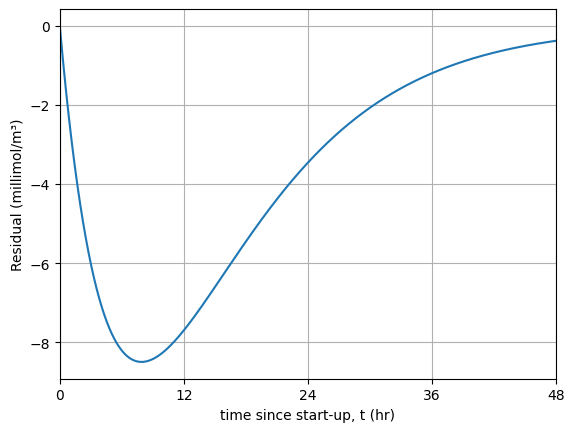

In [511]:
Core.restart()

range = 48
t_rise = time[begin*3600:range*3600]
I_rise = Iodine.concentration[begin*3600:range*3600]
Xe_rise = Xenon.concentration[begin*3600:range*3600]

analytical = riseI(Iodine.concentration[0],Core.eqI,t_rise)
residual = (I_rise-analytical)
r_squared = r2_score(analytical,I_rise)

print(f'Iodine R2: {r_squared}')
print(f'Iodine 1-R2: {1-r_squared}')

print(Core.eqI)
print(Core.eqI*((Xenon.gamma+Iodine.gamma)/(Xenon.lamda+Xenon.sigma*Core.phi)*Iodine.lamda/Iodine.gamma))

analytical = riseXe(Xenon.concentration[0],Core.eqXe,t_rise)
residual = (Xe_rise-analytical)
r_squared = r2_score(analytical,Xe_rise)

#print(Xe_rise)
#print(analytical)

print('Xenon Verification only valid when the initial Iodine concentration is manually set to its equilibrium - Not a representation of real operation')
print(f'Xenon R2: {r_squared}')
print(f'Xenon 1-R2: {1-r_squared}')

plt.figure()
plt.plot(t_rise/3600,residual)
plt.xlim(0,48)
plt.xticks([0,12,24,36,48])
plt.xlabel('time since start-up, t (hr)')
plt.ylabel(f'Residual (millimol/m\N{SUPERSCRIPT THREE})')
plt.grid()



###Plot Rise to Equilibrium

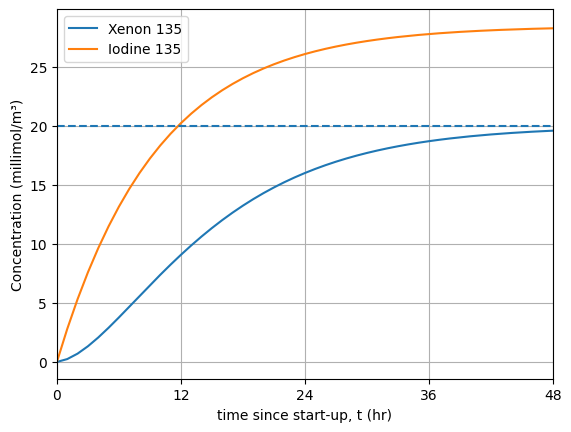

In [512]:
ax =  plt.gca()
plt.xlabel('time since start-up, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(0,48)
plt.xticks([0,12,24,36,48])
plt.plot(time[::3600]/3600,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.grid()
plt.legend(loc='best')
plt.savefig('./img/start-up.png')

###Verify After Scram

In [513]:
range = 48
t_scram = time[scram*3600:(scram+range)*3600]-scram*3600
I_scram = Iodine.concentration[scram*3600:(scram+range)*3600]
Xe_scram = Xenon.concentration[scram*3600:(scram+range)*3600]

analytical = scramI(Core.eqI,t_scram)
residual = (I_scram-analytical)
r_squared = r2_score(analytical,I_scram)

print(f'Iodine R2: {r_squared}')
print(f'Iodine 1-R2: {1-r_squared}')

analytical = scramXe(Core.eqXe,Core.eqI,t_scram)
residual = (Xe_scram-analytical)
r_squared = r2_score(analytical,Xe_scram)

print(f'Xenon R2: {r_squared}')
print(f'Xenon 1-R2: {1-r_squared}')

Iodine R2: 0.9999999989482818
Iodine 1-R2: 1.051718157007997e-09
Xenon R2: 0.9999999995407185
Xenon 1-R2: 4.5928150171903326e-10


###Plot After Scram

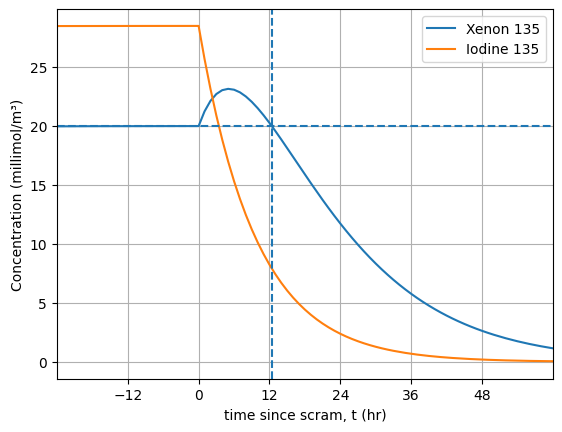

In [514]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/noHe.png')

###Simulate Restart at Xenon peak

In [515]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()
        
    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
    if t==(scram+peak)*3600:
        Core.restart()
#convert to numpy arrays for ease of plotting
rho_t = N2rho(np.array(Xenon.concentration))
Nuclide.numpy()

print(f'Poison Reactivity: {round(N2rho(Core.eqXe)*100,2)}%')

Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


print(f'Xenon peak at {round(time[np.where(np.max(Xenon.concentration)==Xenon.concentration)[0]][0]/3600-scram,2)} hours since scram ')
print(f'Xenon peak: {np.max(Xenon.concentration)} millimol/m3 Xe-135')
print(f'Return to Equilibrium at {round(eqt/3600-scram,1)} hours since scram')


 61%|██████▏   | 365280/594001 [00:18<00:06, 33872.02it/s]

significant (>1ppm) contribution from delayed neutron flux for 437 seconds


100%|██████████| 594001/594001 [00:28<00:00, 20853.72it/s]


Poison Reactivity: 1.38%
Equilibrium Concentrations
28.43608788822039 millimol/m3 I-135
19.960625018443547 millimol/m3 Xe-135
Xenon peak at 5.08 hours since scram 
Xenon peak: 23.111239097599597 millimol/m3 Xe-135
Return to Equilibrium at 7.5 hours since scram


In [516]:
print(f'max build-up rate of {round(max(1e5*np.diff(rho_t[:3600*scram:3600])))} pcm/hr')
print(f'max burnout rate of {round(min(1e5*np.diff(rho_t[::3600])))} pcm/hr')
print(f'minimum overshoot of {round(100*min(rho_t[3600*scram:]),2)}% at {round(np.argmin(rho_t[3600*scram:])/3600-peak,1)} hours after restart')

max build-up rate of 63 pcm/hr
max burnout rate of -96 pcm/hr
minimum overshoot of 1.2% at 10.4 hours after restart


###Plot Peak Restart

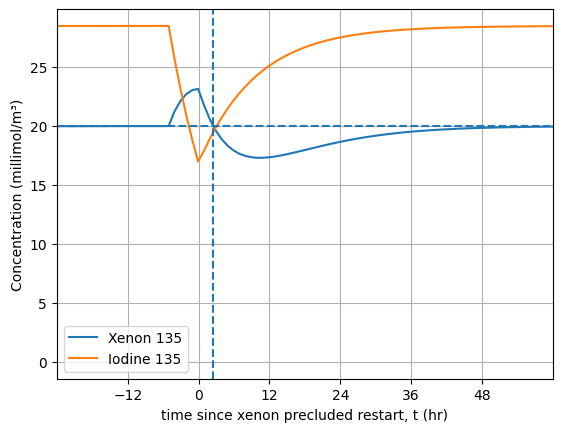

In [517]:
ax =  plt.gca()
plt.xlabel('time since xenon precluded restart, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram-peak,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram-peak,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram-peak,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/peakrestart.png')
plt.show()

###Simulate with Stripper

In [518]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()
        Core.strip(2.15e-7,'off')
        

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()
Core.eqXe = N2C(Core.eqXe)

print(f'Return to equilibrium at {round(eqt/3600-scram,1)} hours since scram)')

 61%|██████▏   | 364015/594001 [00:20<00:15, 15121.67it/s]

significant (>1ppm) contribution from delayed neutron flux for 437 seconds
He flow rate of 2.1310800000000003 mL/hr with reactor off


100%|██████████| 594001/594001 [00:29<00:00, 20085.73it/s]


Return to equilibrium at 8.0 hours since scram)


###Plot after Scram with Stripper

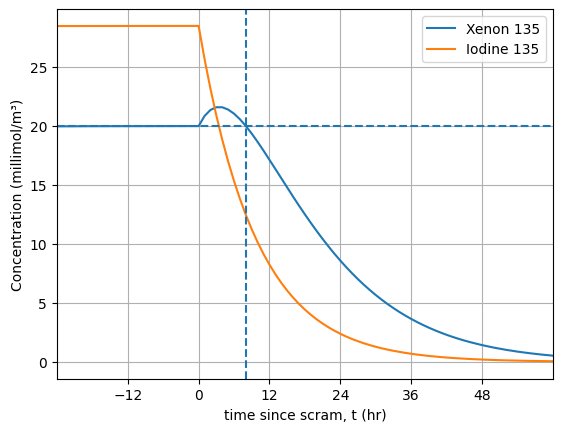

In [519]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/8hr_restart.png')



###Simulate with Stripper (Standby)

In [520]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()
        
    if t==(scram+peak)*3600:
        Core.strip(1.725e-5,'off')

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()
Core.eqXe = N2C(Core.eqXe)

print(f'Return to equilibrium at {round(eqt-(scram+peak)*3600,1)} seconds since call for power')

 61%|██████    | 363489/594001 [00:19<00:15, 14542.06it/s]

significant (>1ppm) contribution from delayed neutron flux for 437 seconds


 64%|██████▍   | 380927/594001 [00:20<00:13, 15967.44it/s]

He flow rate of 170.98199999999997 mL/hr with reactor off


100%|██████████| 594001/594001 [00:29<00:00, 19958.44it/s]


Return to equilibrium at 390.0 seconds since call for power


###Standby Plot 

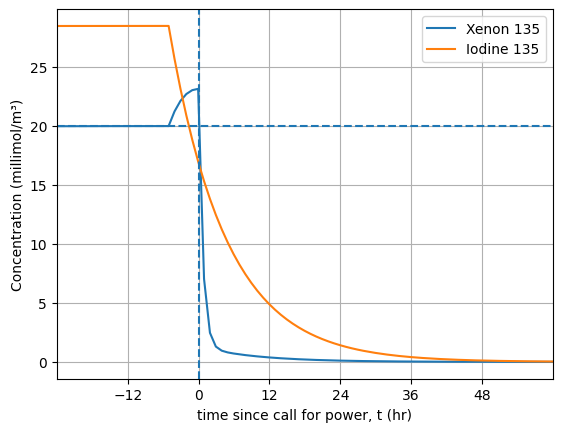

In [521]:
ax =  plt.gca()
plt.xlabel('time since call for power, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram-peak,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram-peak,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram-peak,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/standby_restart.png')


##Simulate EOL Fuel

In [522]:

Core.restart()
Nuclide.reset()
Core.strip(4.9e-6,'on')
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()
    
    if t==scram*3600:
        Core.scram()
        Core.strip(0,'off') 

    #if Core.check and Xenon.concentration[-1] < Core.eqXe:
        #Core.cross()
        #eqt=t
        
#convert to numpy arrays for ease of plotting
#Core.eqXe = Xenon.concentration[-1]
#Core.eqI = Iodine.concentration[-1]
Nuclide.numpy()

print(f'Poison Reactivity: {round(N2rho(Core.eqXe)*100,2)}%')

Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


He flow rate of 145.70639999999997 mL/hr with reactor on


 61%|██████    | 363272/594001 [00:15<00:13, 17346.25it/s]

significant (>1ppm) contribution from delayed neutron flux for 437 seconds
He flow rate of 0.0 mL/hr with reactor off


100%|██████████| 594001/594001 [00:27<00:00, 21462.55it/s]


Poison Reactivity: 0.15%
Equilibrium Concentrations
28.43608788822039 millimol/m3 I-135
2.1069177056393142 millimol/m3 Xe-135


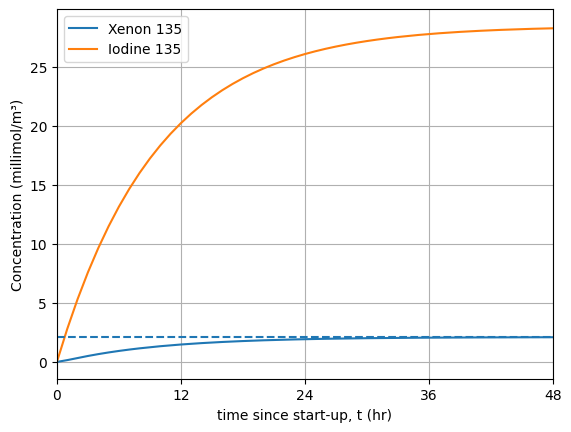

In [523]:
ax =  plt.gca()
plt.xlabel('time since start-up, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(0,48)
plt.xticks([0,12,24,36,48])
plt.plot(time[::3600]/3600,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/EOL-startup.png')

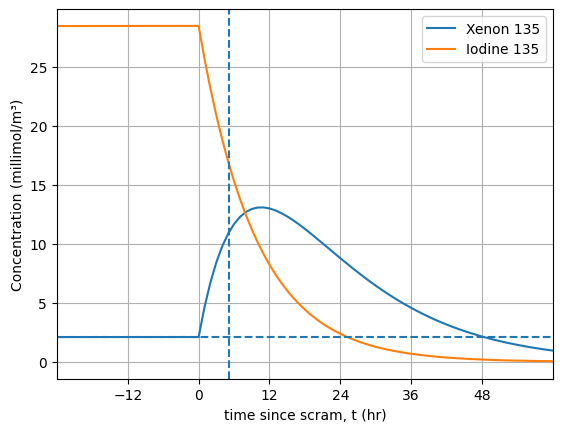

In [524]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/EOL-scram.png')